In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Import Dataset

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, warnings
import tensorflow as tf
import keras 
from keras.models import Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input, RandomContrast, RandomFlip, RandomRotation, RandomTranslation
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
import warnings 
import sys
if not sys.warnoptions:
    warnings.simplefilter('ignore')



## Reproductability

In [17]:
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(333)

In [18]:
x_train = pd.read_csv("../input/ahcd1/csvTrainImages 13440x1024.csv",header=None)
y_train = pd.read_csv("../input/ahcd1/csvTrainLabel 13440x1.csv",header=None)
x_test = pd.read_csv("../input/ahcd1/csvTestImages 3360x1024.csv",header=None)
y_test = pd.read_csv("../input/ahcd1/csvTestLabel 3360x1.csv",header=None)

In [19]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(13440, 1024) (13440, 1)
(3360, 1024) (3360, 1)


In [20]:
x_train = x_train.to_numpy().reshape(-1,32,32,1)
x_test = x_test.to_numpy().reshape(-1,32,32,1)
y_train = to_categorical(y_train-1)
y_test = to_categorical(y_test-1)
(train_inputs, validate_inputs, train_targets, validate_targets) = train_test_split(x_train, y_train, test_size=0.10)

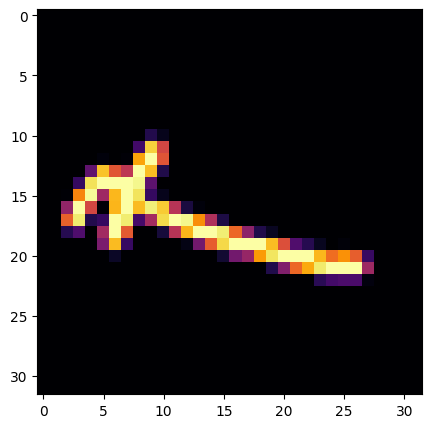

In [21]:
image = x_train[0]
plt.figure(figsize=(5,5))
plt.imshow(image, cmap='inferno')
plt.show()

## Model Definitions

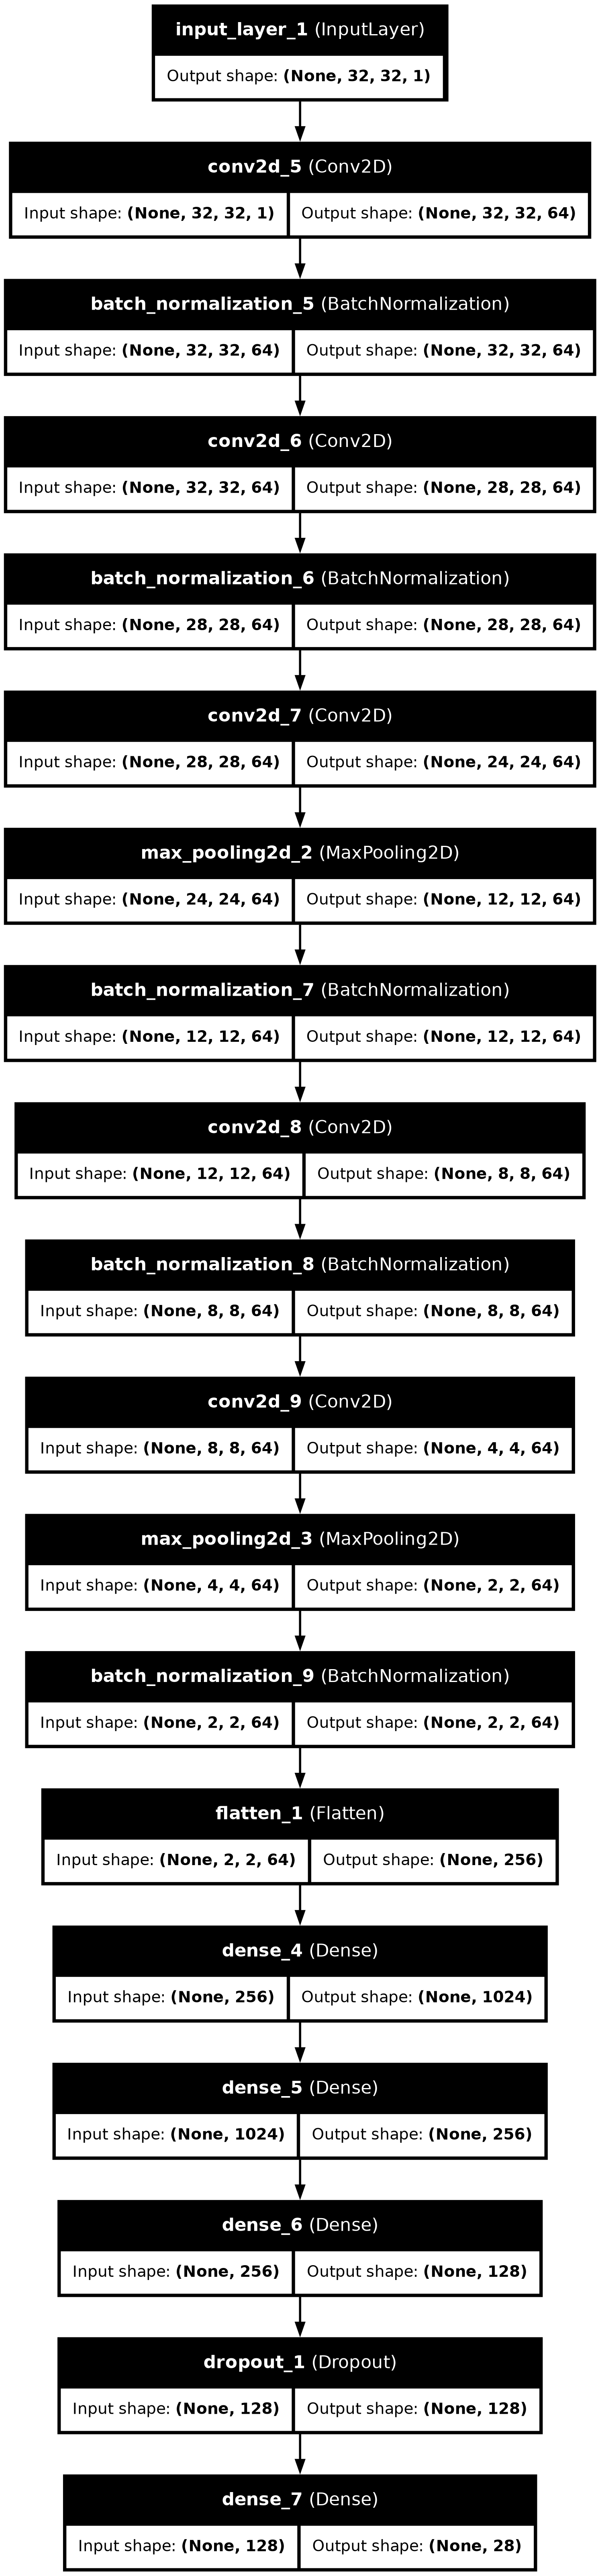

In [22]:
def get_model():
    In = Input(shape=(32,32,1))
        
    x = Conv2D(64, (5,5), padding="same", activation="relu")(In)
    x = BatchNormalization()(x)
    x = Conv2D(64, (5,5), activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (5,5), activation="relu")(x)
    x = MaxPooling2D((2,2))(x)
    x = BatchNormalization()(x)
     
    x = Conv2D(64, (5,5), activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (5,5), activation="relu")(x)
    x = MaxPooling2D((2,2))(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
     
    x = Dense(1024, activation="relu")(x)
    x = Dense(256, activation="relu")(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.2)(x)
    
    Out = Dense(28, activation="softmax")(x)
    
    model = Model(In, Out)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"], jit_compile=False)
    return model

model = get_model()
plot_model(model, show_shapes=True, show_layer_names=True)

## Save Best Data Model

In [23]:
model_checkpoint_callback = ModelCheckpoint(
filepath="Arabic_handwritten_CNN_Model.keras", monitor='val_accuracy', verbose=1, save_best_only= True, mode='max')
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3)


## Data Augmentation

In [24]:
datagen = ImageDataGenerator(
        brightness_range = (0.5, 1.5), 
        rotation_range=20,  
        zoom_range = 0.1, 
        width_shift_range = 0.1,
        height_shift_range = 0.1,  
        horizontal_flip = True,
        vertical_flip = True)

batch_size = 40

train_data = datagen.flow(train_inputs, train_targets, batch_size=batch_size)
validate_data = datagen.flow(validate_inputs, validate_targets, batch_size=batch_size)

## Model Training

In [25]:
history = model.fit(train_data, 
                    epochs = 16,
                    verbose = 1,
                     #steps_per_epoch = x_train.shape[0] // 42,
                    validation_data = validate_data,
                    #validation_steps = x_test.shape[0] // batch_size,
                    callbacks=[model_checkpoint_callback,early_stopping]
                   )

Epoch 1/16
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.1327 - loss: 2.9339
Epoch 1: val_accuracy improved from -inf to 0.32217, saving model to Arabic_handwritten_CNN_Model.keras
303/303 ━━━━━━━━━━━━━━━━━━━━ 157s 502ms/step - accuracy: 0.1330 - loss: 2.9327 - val_accuracy: 0.3222 - val_loss: 2.2604
Epoch 2/16
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.4257 - loss: 1.7373
Epoch 2: val_accuracy improved from 0.32217 to 0.52455, saving model to Arabic_handwritten_CNN_Model.keras
303/303 ━━━━━━━━━━━━━━━━━━━━ 151s 497ms/step - accuracy: 0.4258 - loss: 1.7369 - val_accuracy: 0.5246 - val_loss: 1.5235
Epoch 3/16
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.5900 - loss: 1.2301
Epoch 3: val_accuracy improved from 0.52455 to 0.65253, saving model to Arabic_handwritten_CNN_Model.keras
303/303 ━━━━━━━━━━━━━━━━━━━━ 151s 498ms/step - accuracy: 0.5901 - loss: 1.2299 - val_accuracy: 0.6525 - val_loss: 1.0839
Epoch 4/16
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step -

## Model Evaluation

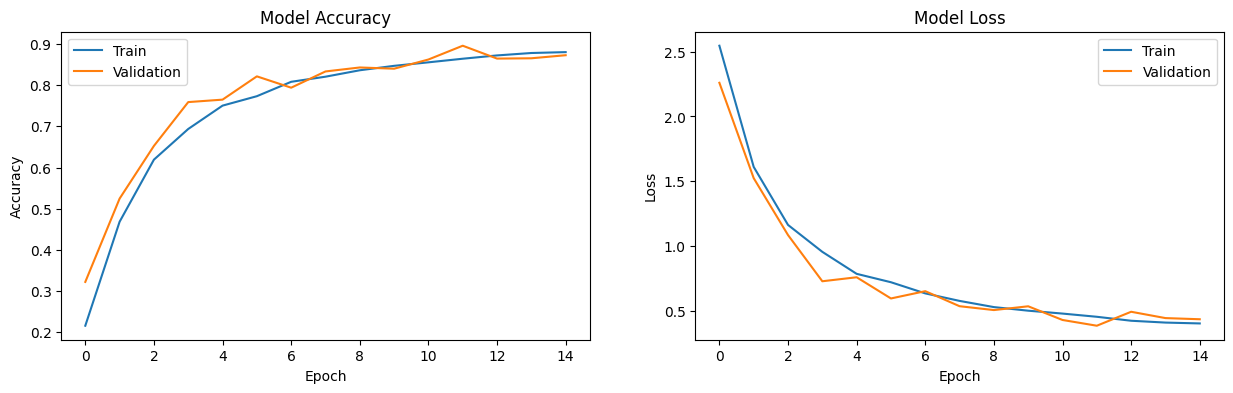

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'])
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'])

plt.show()

In [27]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print('The model accuracy is ' + f"{test_accuracy*100:.1f}" + '%')

105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.8522 - loss: 0.4966
The model accuracy is 86.5%


In [28]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 64)       │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 64)       │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 2, 2, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 28)             │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,923,350 (11.15 MB)

 Trainable params: 974,236 (3.72 MB)

 Non-trainable params: 640 (2.50 KB)

 Optimizer params: 1,948,474 (7.43 MB)